# Source
Notebook obtained from https://github.com/TeamHG-Memex/sklearn-crfsuite/blob/master/docs/CoNLL2002.ipynb

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

## Let's use CoNLL 2002 data to build a NER system

CoNLL2002 corpus is available in NLTK. We use Spanish data.

In [9]:
import os
nltk.download(info_or_id='conll2002', download_dir=os.environ["MARVIN_DATA_PATH"])
nltk.corpus.conll2002.fileids()

[nltk_data] Downloading package conll2002 to
[nltk_data]     /home/erick/marvin/data...
[nltk_data]   Unzipping corpora/conll2002.zip.


[u'esp.testa',
 u'esp.testb',
 u'esp.train',
 u'ned.testa',
 u'ned.testb',
 u'ned.train']

In [10]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

CPU times: user 1.9 s, sys: 32 ms, total: 1.94 s
Wall time: 1.94 s


In [11]:
train_sents[0]

[(u'Melbourne', u'NP', u'B-LOC'),
 (u'(', u'Fpa', u'O'),
 (u'Australia', u'NP', u'B-LOC'),
 (u')', u'Fpt', u'O'),
 (u',', u'Fc', u'O'),
 (u'25', u'Z', u'O'),
 (u'may', u'NC', u'O'),
 (u'(', u'Fpa', u'O'),
 (u'EFE', u'NC', u'B-ORG'),
 (u')', u'Fpt', u'O'),
 (u'.', u'Fp', u'O')]

## Features

Next, define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used. 

This makes a simple baseline, but you certainly can add and remove some features to get (much?) better results - experiment with it.

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

In [12]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],        
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

This is what word2features extracts:

In [13]:
sent2features(train_sents[0])[0]

{'+1:postag': u'Fpa',
 '+1:postag[:2]': u'Fp',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': u'(',
 'BOS': True,
 'bias': 1.0,
 'postag': u'NP',
 'postag[:2]': u'NP',
 'word.isdigit()': False,
 'word.istitle()': True,
 'word.isupper()': False,
 'word.lower()': u'melbourne',
 'word[-2:]': u'ne',
 'word[-3:]': u'rne'}

Extract features from the data:

In [14]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 964 ms, sys: 84 ms, total: 1.05 s
Wall time: 1.04 s


## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [15]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 50.3 s, sys: 76 ms, total: 50.4 s
Wall time: 50.4 s


## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [16]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [17]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.7964686316443963

Inspect per-class results in more detail:

In [18]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-LOC      0.810     0.784     0.797      1084
      I-LOC      0.690     0.637     0.662       325
     B-MISC      0.731     0.569     0.640       339
     I-MISC      0.699     0.589     0.639       557
      B-ORG      0.807     0.832     0.820      1400
      I-ORG      0.852     0.786     0.818      1104
      B-PER      0.850     0.884     0.867       735
      I-PER      0.893     0.943     0.917       634

avg / total      0.809     0.787     0.796      6178



## Hyperparameter Optimization

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

I takes quite a lot of CPU time and RAM (we're fitting a model ``50 * 3 = 150`` times), so grab a tea and be patient, or reduce n_iter in RandomizedSearchCV, or fit model only on a subset of training data.

In [19]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 60.1min finished


CPU times: user 57min 29s, sys: 3min 9s, total: 1h 38s
Wall time: 1h 47s


Best result:

In [20]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

('best params:', {'c2': 0.10789964607864502, 'c1': 0.082422264927260847})
('best CV score:', 0.7488384174737374)
model size: 1.00M


### Check parameter space

A chart which shows which ``c1`` and ``c2`` values have RandomizedSearchCV checked. Red color means better results, blue means worse.

Dark blue => 0.7, dark red => 0.7488


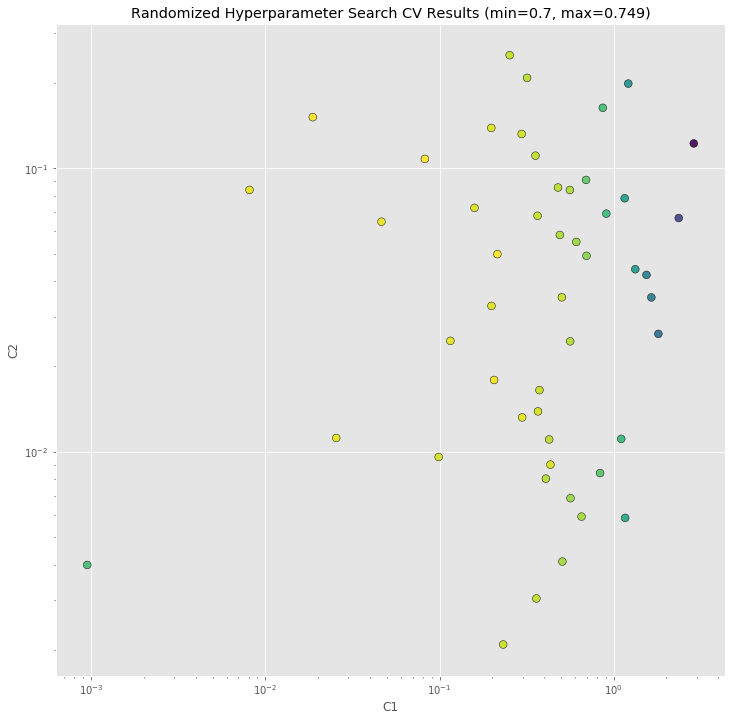

In [21]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Check best estimator on our test data

As you can see, quality is improved.

In [22]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-LOC      0.805     0.785     0.795      1084
      I-LOC      0.684     0.634     0.658       325
     B-MISC      0.732     0.555     0.631       339
     I-MISC      0.710     0.585     0.642       557
      B-ORG      0.809     0.831     0.820      1400
      I-ORG      0.846     0.784     0.814      1104
      B-PER      0.843     0.884     0.863       735
      I-PER      0.887     0.943     0.914       634

avg / total      0.807     0.785     0.794      6178



## Let's check what classifier learned

In [23]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.334446
I-ORG  -> I-ORG   7.030940
B-MISC -> I-MISC  6.783790
I-MISC -> I-MISC  6.598757
B-PER  -> I-PER   6.433439
B-LOC  -> I-LOC   5.576398
I-PER  -> I-PER   5.103914
I-LOC  -> I-LOC   4.817735
O      -> O       3.842562
O      -> B-ORG   2.881719
O      -> B-PER   2.460622
O      -> B-LOC   1.987097
O      -> B-MISC  1.923615
I-PER  -> B-LOC   0.683960
B-LOC  -> B-LOC   0.555455
B-ORG  -> B-LOC   0.518045
B-ORG  -> O       0.462240
B-MISC -> B-ORG   0.400810
B-MISC -> O       -0.088127
B-MISC -> B-LOC   -0.116985

Top unlikely transitions:
I-LOC  -> B-MISC  -1.930706
B-ORG  -> I-LOC   -1.932481
I-MISC -> I-ORG   -1.997492
I-ORG  -> B-LOC   -2.039883
I-ORG  -> I-PER   -2.048299
I-PER  -> I-LOC   -2.184483
B-PER  -> B-MISC  -2.208687
I-MISC -> B-LOC   -2.257005
I-PER  -> B-ORG   -2.263856
I-ORG  -> B-MISC  -2.359342
B-ORG  -> B-MISC  -2.378339
I-ORG  -> I-LOC   -2.604778
I-PER  -> B-MISC  -2.639234
I-MISC -> I-LOC   -2.715389
B-PER  -> B-PER

We can see that, for example, it is very likely that the beginning of an organization name (B-ORG) will be followed by a token inside organization name (I-ORG), but transitions to I-ORG from tokens with other labels are penalized.

Check the state features:

In [24]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
9.343606 B-ORG    word.lower():efe-cantabria
8.392982 B-ORG    word.lower():psoe-progresistas
6.135893 I-ORG    -1:word.lower():l
4.805159 B-ORG    word.lower():xfera
4.762416 O        BOS
4.749045 B-LOC    -1:word.lower():cantabria
4.668822 B-MISC   word.lower():justicia
4.663432 B-ORG    word.lower():telefónica
4.638782 B-LOC    word.lower():líbano
4.637360 B-ORG    word[-2:]:-e
4.583706 B-MISC   word.lower():diversia
4.461872 O        word.lower():r.
4.461872 O        word[-3:]:R.
4.411131 B-MISC   word.lower():competencia
4.274454 B-ORG    word.isupper()
4.267406 B-PER    -1:word.lower():según
4.179659 B-ORG    word.lower():petrobras
4.173969 B-ORG    word.lower():terra
4.166028 I-LOC    -1:word.lower():calle
4.157661 O        word[-2:]:B
4.157661 O        word.lower():b
4.157661 O        word[-3:]:B
4.147704 O        bias
4.094584 B-ORG    word.lower():esquerra
4.069812 B-ORG    word.lower():coag-extremadura
4.014632 B-LOC    word.lower():estrecho
3.938635 B-ORG    w



Some observations:

   * **9.385823 B-ORG word.lower():psoe-progresistas** - the model remembered names of some entities - maybe it is overfit, or maybe our features are not adequate, or maybe remembering is indeed helpful;
   * **4.636151 I-LOC -1:word.lower():calle:** "calle" is a street in Spanish; model learns that if a previous word was "calle" then the token is likely a part of location;
   * **-5.632036 O word.isupper()**, **-8.215073 O word.istitle()** : UPPERCASED or TitleCased words are likely entities of some kind;
   * **-2.097561 O postag:NP** - proper nouns (NP is a proper noun in the Spanish tagset) are often entities.

What to do next

    * Load 'testa' Spanish data.
    * Use it to develop better features and to find best model parameters.
    * Apply the model to 'testb' data again.

The model in this notebook is just a starting point; you certainly can do better!

